Import Required Packages

In [82]:
import boto3
import sagemaker
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

1. Prepare Datasets

Import the S3 data into SageMaker

In [2]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


Store S3 locations

In [3]:
s3_public_path_kaggle = "s3://collegeaffordability317/Kaggle/"
s3_public_path_tuition = "s3://collegeaffordability317/TuitionTracker/"
s3_public_path_usda = "s3://collegeaffordability317/USDA/"
s3_public_path_usde = "s3://collegeaffordability317/USDE/"

In [4]:
%store s3_public_path_kaggle
%store s3_public_path_tuition
%store s3_public_path_usda
%store s3_public_path_usde

Stored 's3_public_path_kaggle' (str)
Stored 's3_public_path_tuition' (str)
Stored 's3_public_path_usda' (str)
Stored 's3_public_path_usde' (str)


Show all the data files for the project

In [5]:
!aws s3 ls $s3_public_path_kaggle

2024-03-25 00:16:36   14081604 college_data.csv


In [6]:
!aws s3 ls $s3_public_path_tuition --recursive

2024-03-24 19:25:25          0 TuitionTracker/DataDictionary/
2024-03-24 19:25:37      21527 TuitionTracker/DataDictionary/DataDictionary.xlsx
2024-03-24 19:24:22          0 TuitionTracker/GradRates/
2024-03-24 19:24:45     838246 TuitionTracker/GradRates/GradRates.csv
2024-03-24 19:24:55          0 TuitionTracker/NetPrice/
2024-03-24 19:25:12    1319314 TuitionTracker/NetPrice/NetPrice.csv
2024-03-24 19:23:55          0 TuitionTracker/RetentionRates/
2024-03-24 19:24:08    1382164 TuitionTracker/RetentionRates/RetentionRates.csv
2024-03-24 19:20:50          0 TuitionTracker/StickerPrice/
2024-03-24 19:21:49     653000 TuitionTracker/StickerPrice/StickerPrice.csv


In [7]:
!aws s3 ls $s3_public_path_usda --recursive

2024-03-24 19:26:33          0 USDA/Education/
2024-03-24 19:26:58    1610608 USDA/Education/Education.xlsx
2024-03-24 19:28:03          0 USDA/PovertyEstimates/
2024-03-24 23:00:25     449799 USDA/PovertyEstimates/PovertyEstimates.csv
2024-03-25 22:15:58     187092 USDA/PovertyTableWithState/20240325_221556_00069_795ia_cfa99626-d392-4100-8b4f-0cfe8f1c1388.gz
2024-03-24 19:28:24          0 USDA/Unemployment/
2024-03-24 22:59:49    1618804 USDA/Unemployment/Unemployment.csv


In [8]:
!aws s3 ls $s3_public_path_usde

2024-03-17 16:06:52      59904 FedStudentAidPortfolioByAge.xls
2024-03-17 16:06:53      68096 FedStudentAidPortfolioByDebtSize.xls
2024-03-17 16:06:53      62976 FedStudentAidPortfolioByLoanType.xls
2024-03-17 16:06:53      50176 FedStudentAidPortfolioByLocation.xls
2024-03-17 16:06:54      60928 FedStudentAidPortfolioBySchoolType.xls
2024-03-17 16:06:54      61952 FedStudentAidPortfolioSummary.xls
2024-03-17 16:06:55      52224 PortfolioByAgeAndDebtSize.xls
2024-03-17 16:06:55      91648 PortfolioByDelinquencyStatus.xls
2024-03-17 16:06:56      57856 PortfolioByLocationAndAge.xls
2024-03-17 16:06:56      58368 PortfolioByLocationAndDebtSize.xls
2024-03-17 16:06:56     147456 PortfolioByRepaymentPlan.xls


2. Athena DB

Data Wrangling

In [9]:
from pyathena import connect

# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [10]:
# Set Athena parameters
college_affordability_database = 'collegeaffordability317'
table_name = 'college_data'

In [11]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [12]:
statement = "CREATE DATABASE IF NOT EXISTS {}".format(college_affordability_database)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS collegeaffordability317


""


In [13]:
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(10)

,database_name
0,collegeaffordability317
1,default
2,dsoaws
3,sagemaker_featurestore


Populate Tables

In [14]:
tuition_tracker_dir = 's3://collegeaffordability317/TuitionTracker/'
usda_dir = 's3://collegeaffordability317/USDA/'
kaggle_dir = 's3://collegeaffordability317/Kaggle/'

In [35]:
# Drop the table if it already exists
university_table = 'University'
pd.read_sql(f'DROP TABLE IF EXISTS {college_affordability_database}.{university_table}', conn)

# Define the CREATE TABLE statement with data types in lowercase
create_university_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {college_affordability_database}.{university_table} (
    UNITID INT,
    INSTNM STRING,
    CITY STRING,
    STABBR STRING,
    ZIP STRING,
    REGION STRING,
    PREDDEG STRING,
    LOCALE INT,
    LATITUDE FLOAT,
    LONGITUDE FLOAT,
    CCBASIC STRING,
    CCUGPROF STRING,
    CCSIZSET STRING,
    ADM_RATE_ALL FLOAT,
    PPTUG_EF FLOAT,
    SAT_AVG_ALL INT,
    COSTT4_A INT,
    CONTROL STRING,
    TUITIONFEE_IN INT,
    TUITIONFEE_OUT INT,
    MEDIAN_HH_INC FLOAT,
    MN_EARN_WNE_INDEP0_P10 INT,
    MN_EARN_WNE_INDEP1_P10 INT,
    UGDS_WHITE FLOAT,
    UGDS_BLACK FLOAT,
    UGDS_HISP FLOAT,
    UGDS_ASIAN FLOAT,
    UGDS_AIAN FLOAT,
    UGDS_NHPI FLOAT,
    UGDS_2MOR FLOAT,
    UGDS_NRA FLOAT,
    UGDS_UNKN FLOAT,
    year INT
    )
    ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ','
    LOCATION '{kaggle_dir}'
    TBLPROPERTIES ('skip.header.line.count'='1')
"""

# Execute create table statement
pd.read_sql(create_university_table, conn)

pd.read_sql(f'SELECT * FROM {college_affordability_database}.{university_table} LIMIT 10', conn)

,unitid,instnm,city,stabbr,zip,region,preddeg,locale,latitude,longitude,...,ugds_white,ugds_black,ugds_hisp,ugds_asian,ugds_aian,ugds_nhpi,ugds_2mor,ugds_nra,ugds_unkn,year
0,100654,Alabama A & M University,Normal,AL,35762,Southeast (AL AR FL GA KY LA MS NC SC TN VA WV),Predominantly bachelor's-degree granting,None,None,None,...,None,None,None,None,None,None,None,0.0402,0.0017,2001
1,100663,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southeast (AL AR FL GA KY LA MS NC SC TN VA WV),Predominantly bachelor's-degree granting,None,None,None,...,None,None,None,None,None,None,None,0.0330,0.0255,2001
2,100706,University of Alabama in Huntsville,Huntsville,AL,35899,Southeast (AL AR FL GA KY LA MS NC SC TN VA WV),Predominantly bachelor's-degree granting,None,None,None,...,None,None,None,None,None,None,None,0.0396,0.0000,2001
3,100751,The University of Alabama,Tuscaloosa,AL,35487-0100,Southeast (AL AR FL GA KY LA MS NC SC TN VA WV),Predominantly bachelor's-degree granting,None,None,None,...,None,None,None,None,None,None,None,0.0159,0.0000,2001
4,100858,Auburn University,Auburn,AL,36849,Southeast (AL AR FL GA KY LA MS NC SC TN VA WV),Predominantly bachelor's-degree granting,None,None,None,...,None,None,None,None,None,None,None,0.0084,0.0016,2001
5,100937,Birmingham-Southern College,Birmingham,AL,35254,Southeast (AL AR FL GA KY LA MS NC SC TN VA WV),Predominantly bachelor's-degree granting,None,None,None,...,None,None,None,None,None,None,None,0.0007,0.0060,2001
6,101116,South University-Montgomery,Montgomery,AL,36116,Southeast (AL AR FL GA KY LA MS NC SC TN VA WV),Predominantly associate's-degree granting,None,None,None,...,None,None,None,None,None,None,None,0.0000,0.0000,2001
7,101189,Faulkner University,Montgomery,AL,36109-3390,Southeast (AL AR FL GA KY LA MS NC SC TN VA WV),Predominantly bachelor's-degree granting,None,None,None,...,None,None,None,None,None,None,None,0.0084,0.0118,2001
8,101198,FAULKNER UNIVERSITY-BIRMINGHAM,BIRMINGHAM,AL,35216-4506,Southeast (AL AR FL GA KY LA MS NC SC TN VA WV),Predominantly bachelor's-degree granting,None,None,None,...,None,None,None,None,None,None,None,0.0034,0.0103,2001
9,101213,FAULKNER UNIVERSITY,HUNTSVILLE,AL,35805-1963,Southeast (AL AR FL GA KY LA MS NC SC TN VA WV),Predominantly bachelor's-degree granting,None,None,None,...,None,None,None,None,None,None,None,0.0034,0.0103,2001


In [16]:
# Drop the table if it already exists
sticker_price_table = 'StickerPrice'
pd.read_sql(f'DROP TABLE IF EXISTS {college_affordability_database}.{sticker_price_table}', conn)

# Define the CREATE TABLE statement with data types in lowercase
create_sticker_price_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {college_affordability_database}.{sticker_price_table} (
    unit_id INT,
    institution_name STRING,
    sector INT,
    total_price_in_state_on_campus_2021_2022 FLOAT,
    total_price_in_state_off_campus_wo_fam_2021_2022 FLOAT,
    total_price_in_state_off_campus_w_fam_2021_2022 FLOAT,
    total_price_in_state_on_campus_2020_2021 FLOAT,
    total_price_in_state_off_campus_wo_fam_2020_2021 FLOAT,
    total_price_in_state_off_campus_w_fam_2020_2021 FLOAT,
    total_price_in_state_on_campus_2019_2020 FLOAT,
    total_price_in_state_off_campus_wo_fam_2019_2020 FLOAT,
    total_price_in_state_off_campus_w_fam_2019_2020 FLOAT,
    total_price_in_state_on_campus_2018_2019 FLOAT,
    total_price_in_state_off_campus_wo_fam_2018_2019 FLOAT,
    total_price_in_state_off_campus_w_fam_2018_2019 FLOAT,
    total_price_in_state_on_campus_2017_2018 FLOAT,
    total_price_in_state_off_campus_wo_fam_2017_2018 FLOAT,
    total_price_in_state_off_campus_w_fam_2017_2018 FLOAT,
    total_price_in_state_on_campus_2016_2017 FLOAT,
    total_price_in_state_off_campus_wo_fam_2016_2017 FLOAT,
    total_price_in_state_off_campus_w_fam_2016_2017 FLOAT,
    total_price_in_state_on_campus_2015_2016 FLOAT,
    total_price_in_state_off_campus_wo_fam_2015_2016 FLOAT,
    total_price_in_state_off_campus_w_fam_2015_2016 FLOAT,
    total_price_in_state_on_campus_2014_2015 FLOAT,
    total_price_in_state_off_campus_wo_fam_2014_2015 FLOAT,
    total_price_in_state_off_campus_w_fam_2014_2015 FLOAT,
    total_price_in_state_on_campus_2013_2014 FLOAT,
    total_price_in_state_off_campus_wo_fam_2013_2014 FLOAT,
    total_price_in_state_off_campus_w_fam_2013_2014 FLOAT,
    total_price_in_state_on_campus_2012_2013 FLOAT,
    total_price_in_state_off_campus_wo_fam_2012_2013 FLOAT,
    total_price_in_state_off_campus_w_fam_2012_2013 FLOAT,
    total_price_in_state_on_campus_2011_2012 FLOAT,
    total_price_in_state_off_campus_wo_fam_2011_2012 FLOAT,
    total_price_in_state_off_campus_w_fam_2011_2012 FLOAT
    )
    ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ','
    LOCATION '{tuition_tracker_dir}/{sticker_price_table}'
    TBLPROPERTIES ('skip.header.line.count'='1')
"""

# Execute create table statement
pd.read_sql(create_sticker_price_table, conn)

pd.read_sql(f'SELECT * FROM {college_affordability_database}.{sticker_price_table} LIMIT 10', conn)

,unit_id,institution_name,sector,total_price_in_state_on_campus_2021_2022,total_price_in_state_off_campus_wo_fam_2021_2022,total_price_in_state_off_campus_w_fam_2021_2022,total_price_in_state_on_campus_2020_2021,total_price_in_state_off_campus_wo_fam_2020_2021,total_price_in_state_off_campus_w_fam_2020_2021,total_price_in_state_on_campus_2019_2020,...,total_price_in_state_off_campus_w_fam_2014_2015,total_price_in_state_on_campus_2013_2014,total_price_in_state_off_campus_wo_fam_2013_2014,total_price_in_state_off_campus_w_fam_2013_2014,total_price_in_state_on_campus_2012_2013,total_price_in_state_off_campus_wo_fam_2012_2013,total_price_in_state_off_campus_w_fam_2012_2013,total_price_in_state_on_campus_2011_2012,total_price_in_state_off_campus_wo_fam_2011_2012,total_price_in_state_off_campus_w_fam_2011_2012
0,180203,Aaniiih Nakoda College,1,NaN,17030.0,8510.0,NaN,17030.0,8510.0,NaN,...,8510.0,NaN,17030.0,8510.0,NaN,17030.0,8510.0,NaN,17030.0,8510.0
1,222178,Abilene Christian University,2,55500.0,55500.0,43872.0,53672.0,53672.0,42322.0,51887.0,...,34100.0,41800.0,41800.0,33000.0,39900.0,39900.0,31250.0,38250.0,NaN,NaN
2,497037,Abilene Christian University-Undergraduate Online,2,NaN,30670.0,19042.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,138558,Abraham Baldwin Agricultural College,1,15727.0,13965.0,7765.0,15575.0,13865.0,7665.0,15479.0,...,6894.0,17503.0,13188.0,7578.0,16550.0,12619.0,7009.0,12347.0,NaN,NaN
4,488031,Abraham Lincoln University,3,NaN,27133.0,11365.0,NaN,25576.0,11176.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,172866,Academy College,3,NaN,38118.0,29579.0,NaN,38182.0,29643.0,NaN,...,28772.0,NaN,30165.0,22965.0,NaN,31504.0,24304.0,NaN,30821.0,23621.0
6,412173,Academy for Nursing and Health Occupations,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,108232,Academy of Art University,3,49222.0,48772.0,31032.0,47174.0,47078.0,30020.0,46724.0,...,25752.0,37828.0,36386.0,25226.0,36884.0,35436.0,24592.0,36202.0,34628.0,23891.0
8,487658,Academy of Interactive Entertainment,5,NaN,36621.0,27513.0,NaN,37522.0,27142.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,439969,Acupuncture and Massage College,3,NaN,41073.0,17761.0,NaN,39281.0,17561.0,NaN,...,16221.0,NaN,23843.0,15355.0,NaN,NaN,NaN,NaN,30111.0,15603.0


In [17]:
# Drop the table if it already exists
net_price_table = 'NetPrice'
pd.read_sql(f'DROP TABLE IF EXISTS {college_affordability_database}.{net_price_table}', conn)

# Define the CREATE TABLE statement with data types in lowercase
create_net_price_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {college_affordability_database}.{net_price_table} (
    unit_id int,
    institution_name string,
    sector int,
    avg_net_price_grants_scholarship_2020_2021 float,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2020_2021 float,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2020_2021 float,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2020_2021 float,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2020_2021 float,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2020_2021 float,
    avg_net_price_grants_scholarship_2019_2020 float,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2019_2020 float,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2019_2020 float,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2019_2020 float,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2019_2020 float,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2019_2020 float,
    avg_net_price_grants_scholarship_2018_2019 float,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2018_2019 float,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2018_2019 float,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2018_2019 float,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2018_2019 float,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2018_2019 float,
    avg_net_price_grants_scholarship_2017_2018 float,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2017_2018 float,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2017_2018 float,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2017_2018 float,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2017_2018 float,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2017_2018 float,
    avg_net_price_grants_scholarship_2016_2017 float,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2016_2017 float,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2016_2017 float,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2016_2017 float,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2016_2017 float,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2016_2017 float,
    avg_net_price_grants_scholarship_2015_2016 float,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2015_2016 float,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2015_2016 float,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2015_2016 float,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2015_2016 float,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2015_2016 float,
    avg_net_price_grants_scholarship_2014_2015 float,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2014_2015 float,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2014_2015 float,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2014_2015 float,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2014_2015 float,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2014_2015 float,
    avg_net_price_grants_scholarship_2013_2014 float,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2013_2014 float,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2013_2014 float,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2013_2014 float,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2013_2014 float,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2013_2014 float,
    avg_net_price_grants_scholarship_2012_2013 float,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2012_2013 float,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2012_2013 float,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2012_2013 float,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2012_2013 float,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2012_2013 float,
    avg_net_price_grants_scholarship_2011_2012 float,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2011_2012 float,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2011_2012 float,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2011_2012 float,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2011_2012 float,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2011_2012 float
    )
    ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ','
    LOCATION '{tuition_tracker_dir}/{net_price_table}'
    TBLPROPERTIES ('skip.header.line.count'='1')
"""

# Execute create table statement
pd.read_sql(create_net_price_table, conn)

pd.read_sql(f'SELECT * FROM {college_affordability_database}.{net_price_table} LIMIT 10', conn)

,unit_id,institution_name,sector,avg_net_price_grants_scholarship_2020_2021,avg_net_price_income_0_30k_titleiv_fed_finaid_2020_2021,avg_net_price_income_30k_48k_titleiv_fed_finaid_2020_2021,avg_net_price_income_48k_75k_titleiv_fed_finaid_2020_2021,avg_net_price_income_75k_110k_titleiv_fed_finaid_2020_2021,avg_net_price_income_over_110k_titleiv_fed_finaid_2020_2021,avg_net_price_grants_scholarship_2019_2020,...,avg_net_price_income_30k_48k_titleiv_fed_finaid_2012_2013,avg_net_price_income_48k_75k_titleiv_fed_finaid_2012_2013,avg_net_price_income_75k_110k_titleiv_fed_finaid_2012_2013,avg_net_price_income_over_110k_titleiv_fed_finaid_2012_2013,avg_net_price_grants_scholarship_2011_2012,avg_net_price_income_0_30k_titleiv_fed_finaid_2011_2012,avg_net_price_income_30k_48k_titleiv_fed_finaid_2011_2012,avg_net_price_income_48k_75k_titleiv_fed_finaid_2011_2012,avg_net_price_income_75k_110k_titleiv_fed_finaid_2011_2012,avg_net_price_income_over_110k_titleiv_fed_finaid_2011_2012
0,180203,Aaniiih Nakoda College,1,8381.0,8119.0,8326.0,10138.0,NaN,NaN,7777.0,...,5024.0,3359.0,NaN,NaN,13201.0,13133.0,13769.0,14069.0,NaN,NaN
1,222178,Abilene Christian University,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,497037,Abilene Christian University-Undergraduate Online,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,138558,Abraham Baldwin Agricultural College,1,7744.0,4784.0,5862.0,8408.0,10953.0,10568.0,8106.0,...,8862.0,10959.0,12342.0,12946.0,7518.0,6026.0,6895.0,9511.0,11080.0,11182.0
4,488031,Abraham Lincoln University,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,172866,Academy College,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,412173,Academy for Nursing and Health Occupations,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,108232,Academy of Art University,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,487658,Academy of Interactive Entertainment,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,439969,Acupuncture and Massage College,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Drop the table if it already exists
poverty_table = 'PovertyEstimates'
pd.read_sql(f'DROP TABLE IF EXISTS {college_affordability_database}.{poverty_table}', conn)

# Define the CREATE TABLE statement with data types in lowercase
create_poverty_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {college_affordability_database}.{poverty_table} (
    FIPS_Code INT,
    Stabr STRING,
    Area_name STRING,
    Rural_urban_Continuum_Code_2003 STRING,
    Urban_Influence_Code_2003 STRING,
    Rural_urban_Continuum_Code_2013 STRING,
    Urban_Influence_Code_2013 STRING,
    POVALL_2021 STRING,
    CI90LBALL_2021 STRING,
    CI90UBALL_2021 STRING,
    PCTPOVALL_2021 STRING,
    CI90LBALLP_2021 STRING,
    CI90UBALLP_2021 STRING,
    POV017_2021 STRING,
    CI90LB017_2021 STRING,
    CI90UB017_2021 STRING,
    PCTPOV017_2021 STRING,
    CI90LB017P_2021 STRING,
    CI90UB017P_2021 STRING,
    POV517_2021 STRING,
    CI90LB517_2021 STRING,
    CI90UB517_2021 STRING,
    PCTPOV517_2021 STRING,
    CI90LB517P_2021 STRING,
    CI90UB517P_2021 STRING,
    MEDHHINC_2021 STRING,
    CI90LBINC_2021 STRING,
    CI90UBINC_2021 STRING,
    POV04_2021 STRING,
    CI90LB04_2021 STRING,
    CI90UB04_2021 STRING,
    PCTPOV04_2021 STRING,
    CI90LB04P_2021 STRING,
    CI90UB04P_2021 STRING
    )
    ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ','
    LOCATION '{usda_dir}/{poverty_table}'
    TBLPROPERTIES ('skip.header.line.count'='1')
"""

# Execute create table statement
pd.read_sql(create_poverty_table, conn) 

pd.read_sql(f'SELECT * FROM {college_affordability_database}.{poverty_table} LIMIT 10', conn)

,fips_code,stabr,area_name,rural_urban_continuum_code_2003,urban_influence_code_2003,rural_urban_continuum_code_2013,urban_influence_code_2013,povall_2021,ci90lball_2021,ci90uball_2021,...,ci90ub517p_2021,medhhinc_2021,ci90lbinc_2021,ci90ubinc_2021,pov04_2021,ci90lb04_2021,ci90ub04_2021,pctpov04_2021,ci90lb04p_2021,ci90ub04p_2021
0,0,US,United States,,,,,41393176,41149497,41636855,...,16.3,69717,69583,69851,3349149,3299669,3398629,18.3,18,18.6
1,1000,AL,Alabama,,,,,800848,782169,819527,...,22.5,53990,53218,54762,71220,66888,75552,25.1,23.6,26.6
2,1001,AL,Autauga County,2,2,2,2,6296,4772,7820,...,20.4,66444,60061,72827,,,,,,
3,1003,AL,Baldwin County,4,5,3,2,25526,21599,29453,...,18.5,65658,60723,70593,,,,,,
4,1005,AL,Barbour County,6,6,6,6,5089,3773,6405,...,44.6,38649,34308,42990,,,,,,
5,1007,AL,Bibb County,1,1,1,1,4204,3324,5084,...,35.4,48454,42438,54470,,,,,,
6,1009,AL,Blount County,1,1,1,1,6992,5516,8468,...,20.7,56894,52632,61156,,,,,,
7,1011,AL,Bullock County,6,6,6,6,2764,2161,3367,...,54.3,32027,28131,35923,,,,,,
8,1013,AL,Butler County,6,6,6,6,4226,3385,5067,...,43.7,39442,34974,43910,,,,,,
9,1015,AL,Calhoun County,3,2,3,2,21630,18671,24589,...,30.4,48166,43479,52853,,,,,,


In [19]:
# Drop the table if it already exists
unemployment_table = 'Unemployment'
pd.read_sql(f'DROP TABLE IF EXISTS {college_affordability_database}.{unemployment_table}', conn)

# Define the CREATE TABLE statement with data types in lowercase
create_unemployment_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {college_affordability_database}.{unemployment_table} (
    FIPS_Code INT,
    State STRING,
    Area_Name STRING,  
    Rural_Urban_Continuum_Code_2013 INT,
    Urban_Influence_Code_2013 INT,
    Metro_2013 INT,
    Civilian_labor_force_2000 INT,
    Employed_2000 INT,
    Unemployed_2000 INT,
    Unemployment_rate_2000 FLOAT,
    Civilian_labor_force_2001 INT,
    Employed_2001 INT,
    Unemployed_2001 INT,
    Unemployment_rate_2001 FLOAT,
    Civilian_labor_force_2002 INT,
    Employed_2002 INT,
    Unemployed_2002 INT,
    Unemployment_rate_2002 FLOAT,
    Civilian_labor_force_2003 INT,
    Employed_2003 INT,
    Unemployed_2003 INT,
    Unemployment_rate_2003 FLOAT,
    Civilian_labor_force_2004 INT,
    Employed_2004 INT,
    Unemployed_2004 INT, 
    Unemployment_rate_2004 FLOAT,
    Civilian_labor_force_2005 INT,
    Employed_2005 INT,
    Unemployed_2005 INT,
    Unemployment_rate_2005 FLOAT,
    Civilian_labor_force_2006 INT,
    Employed_2006 INT,
    Unemployed_2006 INT,
    Unemployment_rate_2006 FLOAT,
    Civilian_labor_force_2007 INT,
    Employed_2007 INT,
    Unemployed_2007 INT,
    Unemployment_rate_2007 FLOAT,
    Civilian_labor_force_2008 INT,
    Employed_2008 INT,
    Unemployed_2008 INT,
    Unemployment_rate_2008 FLOAT,
    Civilian_labor_force_2009 INT,
    Employed_2009 INT,
    Unemployed_2009 INT,
    Unemployment_rate_2009 FLOAT,
    Civilian_labor_force_2010 INT,
    Employed_2010 INT,
    Unemployed_2010 INT,
    Unemployment_rate_2010 FLOAT,
    Civilian_labor_force_2011 INT,
    Employed_2011 INT,
    Unemployed_2011 INT,
    Unemployment_rate_2011 FLOAT,
    Civilian_labor_force_2012 INT,
    Employed_2012 INT,
    Unemployed_2012 INT,
    Unemployment_rate_2012 FLOAT,
    Civilian_labor_force_2013 INT,
    Employed_2013 INT,
    Unemployed_2013 INT,
    Unemployment_rate_2013 FLOAT,
    Civilian_labor_force_2014 INT,
    Employed_2014 INT,
    Unemployed_2014 INT,
    Unemployment_rate_2014 FLOAT,
    Civilian_labor_force_2015 INT,
    Employed_2015 INT,
    Unemployed_2015 INT,
    Unemployment_rate_2015 FLOAT,
    Civilian_labor_force_2016 INT,
    Employed_2016 INT,
    Unemployed_2016 INT,
    Unemployment_rate_2016 FLOAT,
    Civilian_labor_force_2017 INT,
    Employed_2017 INT,
    Unemployed_2017 INT,
    Unemployment_rate_2017 FLOAT,
    Civilian_labor_force_2018 INT,
    Employed_2018 INT,
    Unemployed_2018 INT,
    Unemployment_rate_2018 FLOAT,
    Civilian_labor_force_2019 INT,
    Employed_2019 INT,
    Unemployed_2019 INT,
    Unemployment_rate_2019 FLOAT,
    Civilian_labor_force_2020 INT,
    Employed_2020 INT,
    Unemployed_2020 INT,
    Unemployment_rate_2020 FLOAT,
    Civilian_labor_force_2021 INT,
    Employed_2021 INT,
    Unemployed_2021 INT,
    Unemployment_rate_2021 FLOAT,
    Civilian_labor_force_2022 INT,
    Employed_2022 INT,
    Unemployed_2022 INT,
    Unemployment_rate_2022 FLOAT,
    Median_Household_Income_2021 INT,
    Med_HH_Income_Percent_of_State_Total_2021 FLOAT
    )
    ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ','
    LOCATION '{usda_dir}/{unemployment_table}'
    TBLPROPERTIES ('skip.header.line.count'='1')
"""

# Execute create table statement
pd.read_sql(create_unemployment_table, conn)

pd.read_sql(f'SELECT * FROM {college_affordability_database}.{unemployment_table} LIMIT 10', conn)

,fips_code,state,area_name,rural_urban_continuum_code_2013,urban_influence_code_2013,metro_2013,civilian_labor_force_2000,employed_2000,unemployed_2000,unemployment_rate_2000,...,civilian_labor_force_2021,employed_2021,unemployed_2021,unemployment_rate_2021,civilian_labor_force_2022,employed_2022,unemployed_2022,unemployment_rate_2022,median_household_income_2021,med_hh_income_percent_of_state_total_2021
0,0,US,United States,NaN,NaN,NaN,142601576,136904853,5696723,4.0,...,162229903,153544980,8684923,5.4,164781642,158766998,6014644,3.7,69717,NaN
1,1000,AL,Alabama,NaN,NaN,NaN,2147173,2047731,99442,4.6,...,2259349,2183330,76019,3.4,2286028,2226670,59358,2.6,53990,100.0
2,1001,AL,Autauga County AL,2.0,2.0,1.0,21861,20971,890,4.1,...,26545,25809,736,2.8,26789,26181,608,2.3,66444,123.1
3,1003,AL,Baldwin County AL,3.0,2.0,1.0,69979,67370,2609,3.7,...,99953,97034,2919,2.9,102849,100432,2417,2.4,65658,121.6
4,1005,AL,Barbour County AL,6.0,6.0,0.0,11449,10812,637,5.6,...,8280,7821,459,5.5,8241,7906,335,4.1,38649,71.6
5,1007,AL,Bibb County AL,1.0,1.0,1.0,8623,8160,463,5.4,...,8641,8347,294,3.4,8726,8507,219,2.5,48454,89.7
6,1009,AL,Blount County AL,1.0,1.0,1.0,25266,24375,891,3.5,...,25377,24779,598,2.4,25796,25222,574,2.2,56894,105.4
7,1011,AL,Bullock County AL,6.0,6.0,0.0,3997,3656,341,8.5,...,4637,4455,182,3.9,4554,4426,128,2.8,32027,59.3
8,1013,AL,Butler County AL,6.0,6.0,0.0,9221,8496,725,7.9,...,8819,8367,452,5.1,8804,8503,301,3.4,39442,73.1
9,1015,AL,Calhoun County AL,3.0,2.0,1.0,53244,50522,2722,5.1,...,46368,44497,1871,4.0,46140,44741,1399,3.0,48166,89.2


Transform Tables

In [21]:

# Define the new table name
new_poverty_table = "PovertyTableWithState"

# Define the query to create the new table with the desired transformation
create_new_poverty_table_query = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {college_affordability_database}.{new_poverty_table} (
    FIPS_Code INT,
    Stabr STRING,
    Area_name_with_state STRING,
    Rural_urban_Continuum_Code_2003 STRING,
    Urban_Influence_Code_2003 STRING,
    Rural_urban_Continuum_Code_2013 STRING,
    Urban_Influence_Code_2013 STRING,
    POVALL_2021 STRING,
    CI90LBALL_2021 STRING,
    CI90UBALL_2021 STRING,
    PCTPOVALL_2021 STRING,
    CI90LBALLP_2021 STRING,
    CI90UBALLP_2021 STRING,
    POV017_2021 STRING,
    CI90LB017_2021 STRING,
    CI90UB017_2021 STRING,
    PCTPOV017_2021 STRING,
    CI90LB017P_2021 STRING,
    CI90UB017P_2021 STRING,
    POV517_2021 STRING,
    CI90LB517_2021 STRING,
    CI90UB517_2021 STRING,
    PCTPOV517_2021 STRING,
    CI90LB517P_2021 STRING,
    CI90UB517P_2021 STRING,
    MEDHHINC_2021 STRING,
    CI90LBINC_2021 STRING,
    CI90UBINC_2021 STRING,
    POV04_2021 STRING,
    CI90LB04_2021 STRING,
    CI90UB04_2021 STRING,
    PCTPOV04_2021 STRING,
    CI90LB04P_2021 STRING,
    CI90UB04P_2021 STRING
    )
    ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ','
    LOCATION '{usda_dir}/{new_poverty_table}/'
"""

# Execute the query to create the new table with the transformation
pd.read_sql(create_new_poverty_table_query, conn)

# Update the Area_name_with_state column by concatenating Area_name and Stabr
update_area_name_query_poverty = f"""
INSERT INTO {college_affordability_database}.{new_poverty_table}
SELECT
    FIPS_Code,
    Stabr,
    CONCAT(Area_name, ' ', Stabr) AS Area_name_with_state,
    Rural_urban_Continuum_Code_2003,
    Urban_Influence_Code_2003,
    Rural_urban_Continuum_Code_2013,
    Urban_Influence_Code_2013,
    POVALL_2021,
    CI90LBALL_2021,
    CI90UBALL_2021,
    PCTPOVALL_2021,
    CI90LBALLP_2021,
    CI90UBALLP_2021,
    POV017_2021,
    CI90LB017_2021,
    CI90UB017_2021,
    PCTPOV017_2021,
    CI90LB017P_2021,
    CI90UB017P_2021,
    POV517_2021,
    CI90LB517_2021,
    CI90UB517_2021,
    PCTPOV517_2021,
    CI90LB517P_2021,
    CI90UB517P_2021,
    MEDHHINC_2021,
    CI90LBINC_2021,
    CI90UBINC_2021,
    POV04_2021,
    CI90LB04_2021,
    CI90UB04_2021,
    PCTPOV04_2021,
    CI90LB04P_2021,
    CI90UB04P_2021
FROM {college_affordability_database}.{poverty_table}
"""

# Execute the query to update the new table
pd.read_sql(update_area_name_query_poverty, conn)


# Fetch and display data from the new table
pd.read_sql(f'SELECT * FROM {college_affordability_database}.{new_poverty_table} LIMIT 10', conn)

,fips_code,stabr,area_name_with_state,rural_urban_continuum_code_2003,urban_influence_code_2003,rural_urban_continuum_code_2013,urban_influence_code_2013,povall_2021,ci90lball_2021,ci90uball_2021,...,ci90ub517p_2021,medhhinc_2021,ci90lbinc_2021,ci90ubinc_2021,pov04_2021,ci90lb04_2021,ci90ub04_2021,pctpov04_2021,ci90lb04p_2021,ci90ub04p_2021
0,0,US,United States US,,,,,41393176,41149497,41636855,...,16.3,69717,69583,69851,3349149,3299669,3398629,18.3,18,18.6
1,1000,AL,Alabama AL,,,,,800848,782169,819527,...,22.5,53990,53218,54762,71220,66888,75552,25.1,23.6,26.6
2,1001,AL,Autauga County AL,2,2,2,2,6296,4772,7820,...,20.4,66444,60061,72827,,,,,,
3,1003,AL,Baldwin County AL,4,5,3,2,25526,21599,29453,...,18.5,65658,60723,70593,,,,,,
4,1005,AL,Barbour County AL,6,6,6,6,5089,3773,6405,...,44.6,38649,34308,42990,,,,,,
5,1007,AL,Bibb County AL,1,1,1,1,4204,3324,5084,...,35.4,48454,42438,54470,,,,,,
6,1009,AL,Blount County AL,1,1,1,1,6992,5516,8468,...,20.7,56894,52632,61156,,,,,,
7,1011,AL,Bullock County AL,6,6,6,6,2764,2161,3367,...,54.3,32027,28131,35923,,,,,,
8,1013,AL,Butler County AL,6,6,6,6,4226,3385,5067,...,43.7,39442,34974,43910,,,,,,
9,1015,AL,Calhoun County AL,3,2,3,2,21630,18671,24589,...,30.4,48166,43479,52853,,,,,,


In [75]:
# Define the new table name
combined_tables = "JoinedTables"

# Define the query to create the new table with the desired transformation
join_tables = f"""
CREATE TABLE IF NOT EXISTS {college_affordability_database}.{combined_tables} AS (
SELECT DISTINCT uni.INSTNM,
        uni.STABBR,
        uni.CITY,
        uni.ADM_RATE_ALL,
        uni.SAT_AVG_ALL,
        uni.COSTT4_A,
        uni.TUITIONFEE_IN,
        uni.MN_EARN_WNE_INDEP1_P10,
        uni.PREDDEG,
        uni.CONTROL,
        pov.Stabr AS state_abbr,
        pov.Area_name_with_state,
        pov.POVALL_2021,
        pov.CI90LBALL_2021,
        pov.CI90UBALL_2021,
        pov.MEDHHINC_2021,
        pov.CI90LBINC_2021,
        pov.CI90UBINC_2021,
        unemp.Unemployment_rate_2000,
        unemp.Unemployment_rate_2001,
        unemp.Unemployment_rate_2002,
        unemp.Unemployment_rate_2003,
        unemp.Unemployment_rate_2004,
        unemp.Unemployment_rate_2005,
        unemp.Unemployment_rate_2006,
        unemp.Unemployment_rate_2007,
        unemp.Unemployment_rate_2008,
        unemp.Unemployment_rate_2009,
        unemp.Unemployment_rate_2010,
        unemp.Unemployment_rate_2011,
        unemp.Unemployment_rate_2013,
        unemp.Unemployment_rate_2014,
        unemp.Unemployment_rate_2015,
        unemp.Unemployment_rate_2016,
        unemp.Unemployment_rate_2017,
        unemp.Unemployment_rate_2018,
        unemp.Unemployment_rate_2019,
        unemp.Unemployment_rate_2020,
        unemp.Unemployment_rate_2021,
        unemp.Unemployment_rate_2022,
        unemp.Median_Household_Income_2021,
        net.avg_net_price_grants_scholarship_2020_2021,
        net.avg_net_price_grants_scholarship_2019_2020,
        net.avg_net_price_grants_scholarship_2018_2019,
        net.avg_net_price_grants_scholarship_2017_2018,
        net.avg_net_price_grants_scholarship_2016_2017,
        net.avg_net_price_grants_scholarship_2015_2016,
        net.avg_net_price_grants_scholarship_2014_2015,
        net.avg_net_price_grants_scholarship_2013_2014,
        net.avg_net_price_grants_scholarship_2012_2013,
        net.avg_net_price_grants_scholarship_2011_2012,
        unemp.Unemployment_rate_2012
FROM {college_affordability_database}.{university_table} uni
JOIN {college_affordability_database}.{new_poverty_table} pov ON uni.STABBR = pov.Stabr
JOIN {college_affordability_database}.{unemployment_table} unemp ON pov.FIPS_Code = unemp.FIPS_Code
JOIN {college_affordability_database}.{net_price_table} net ON uni.INSTNM = net.institution_name
WHERE uni.year = 2022
)
"""

# Execute the query to create the new table with the transformation
pd.read_sql(join_tables, conn)

# Fetch and display data from the new table
pd.read_sql(f'SELECT * FROM {college_affordability_database}.{combined_tables} LIMIT 10', conn)

,instnm,stabbr,city,adm_rate_all,sat_avg_all,costt4_a,tuitionfee_in,mn_earn_wne_indep1_p10,preddeg,control,...,avg_net_price_grants_scholarship_2020_2021,avg_net_price_grants_scholarship_2019_2020,avg_net_price_grants_scholarship_2018_2019,avg_net_price_grants_scholarship_2017_2018,avg_net_price_grants_scholarship_2016_2017,avg_net_price_grants_scholarship_2015_2016,avg_net_price_grants_scholarship_2014_2015,avg_net_price_grants_scholarship_2013_2014,avg_net_price_grants_scholarship_2012_2013,avg_net_price_grants_scholarship_2011_2012
0,Alabama A & M University,AL,Normal,0.7505,970,None,4664,None,Predominantly bachelor's-degree granting,Public,...,12921.0,15373.0,14604.0,13956.0,15812.0,15547.0,13203.0,14746.0,12887.0,11108.0
1,Alabama A & M University,AL,Normal,0.7505,970,None,4664,None,Predominantly bachelor's-degree granting,Public,...,12921.0,15373.0,14604.0,13956.0,15812.0,15547.0,13203.0,14746.0,12887.0,11108.0
2,Alabama A & M University,AL,Normal,0.7505,970,None,4664,None,Predominantly bachelor's-degree granting,Public,...,12921.0,15373.0,14604.0,13956.0,15812.0,15547.0,13203.0,14746.0,12887.0,11108.0
3,Alabama A & M University,AL,Normal,0.7505,970,None,4664,None,Predominantly bachelor's-degree granting,Public,...,12921.0,15373.0,14604.0,13956.0,15812.0,15547.0,13203.0,14746.0,12887.0,11108.0
4,Alabama A & M University,AL,Normal,0.7505,970,None,4664,None,Predominantly bachelor's-degree granting,Public,...,12921.0,15373.0,14604.0,13956.0,15812.0,15547.0,13203.0,14746.0,12887.0,11108.0
5,Alabama A & M University,AL,Normal,0.7505,970,None,4664,None,Predominantly bachelor's-degree granting,Public,...,12921.0,15373.0,14604.0,13956.0,15812.0,15547.0,13203.0,14746.0,12887.0,11108.0
6,Alabama A & M University,AL,Normal,0.7505,970,None,4664,None,Predominantly bachelor's-degree granting,Public,...,12921.0,15373.0,14604.0,13956.0,15812.0,15547.0,13203.0,14746.0,12887.0,11108.0
7,Alabama A & M University,AL,Normal,0.7505,970,None,4664,None,Predominantly bachelor's-degree granting,Public,...,12921.0,15373.0,14604.0,13956.0,15812.0,15547.0,13203.0,14746.0,12887.0,11108.0
8,Alabama A & M University,AL,Normal,0.7505,970,None,4664,None,Predominantly bachelor's-degree granting,Public,...,12921.0,15373.0,14604.0,13956.0,15812.0,15547.0,13203.0,14746.0,12887.0,11108.0
9,Alabama A & M University,AL,Normal,0.7505,970,None,4664,None,Predominantly bachelor's-degree granting,Public,...,12921.0,15373.0,14604.0,13956.0,15812.0,15547.0,13203.0,14746.0,12887.0,11108.0


3. Exploratory Data Analysis

In [76]:
# Create dataframes from the Athena tables
University = pd.read_sql(f'SELECT * FROM {college_affordability_database}.{university_table}', conn)
StickerPrice = pd.read_sql(f'SELECT * FROM {college_affordability_database}.{sticker_price_table}', conn)
NetPrice = pd.read_sql(f'SELECT * FROM {college_affordability_database}.{net_price_table}', conn)
Poverty = pd.read_sql(f'SELECT * FROM {college_affordability_database}.{unemployment_table}', conn)
Unemployment = pd.read_sql(f'SELECT * FROM {college_affordability_database}.{poverty_table}', conn)
#df = pd.read_sql(f'SELECT * FROM {college_affordability_database}.{combined_tables}', conn)

In [77]:
# get number of rows and columns
print('Number of Rows in University - ', University.shape[0])
print('Number of Columns in University - ', University.shape[1], '\n')

print('Number of Rows in StickerPrice - ', StickerPrice.shape[0])
print('Number of Columns in StickerPrice - ', StickerPrice.shape[1], '\n')

print('Number of Rows in NetPrice - ', NetPrice.shape[0])
print('Number of Columns in NetPrice - ', NetPrice.shape[1], '\n')

print('Number of Rows in Poverty - ', Poverty.shape[0])
print('Number of Columns in Poverty - ', Poverty.shape[1], '\n')

print('Number of Rows in Unemployment - ', Unemployment.shape[0])
print('Number of Columns in Unemployment - ', Unemployment.shape[1], '\n')

Number of Rows in University -  58123
Number of Columns in University -  33 

Number of Rows in StickerPrice -  3240
Number of Columns in StickerPrice -  36 

Number of Rows in NetPrice -  3240
Number of Columns in NetPrice -  63 

Number of Rows in Poverty -  3277
Number of Columns in Poverty -  100 

Number of Rows in Unemployment -  3195
Number of Columns in Unemployment -  34 



Data Types and NULLS

In [78]:
# get number of rows and columns
print('Number of Rows - ', University.shape[0])
print('Number of Columns - ', University.shape[1], '\n')

# inspect datatypes and nulls
data_types = University.dtypes
data_types = pd.DataFrame(data_types)
data_types = data_types.assign(Null_Values = 
                               University.isnull().sum())
data_types.reset_index(inplace = True)
data_types.rename(columns={0:'Data Type',
                          'index': 'Field',
                          'Null_Values': "Nulls"})

Number of Rows -  58123
Number of Columns -  33 



,Field,Data Type,Nulls
0,unitid,int64,0
1,instnm,object,0
2,city,object,0
3,stabbr,object,0
4,zip,object,0
5,region,object,0
6,preddeg,object,0
7,locale,float64,54013
8,latitude,float64,54013
9,longitude,float64,54013


Summary Statistics

In [79]:
#summary statistics
stats = pd.DataFrame(University.describe()).T
stats

,count,mean,std,min,25%,50%,75%,max
unitid,58123.0,934402.730365,4.143870e+06,100654.000000,163286.000000,203234.000000,243443.000000,4.957672e+07
locale,4110.0,19.850122,9.491830e+00,-3.000000,12.000000,21.000000,23.000000,4.300000e+01
latitude,4110.0,38.128463,5.654605e+00,6.909759,34.935519,39.908070,41.718277,6.485756e+01
longitude,4110.0,-87.463017,1.688685e+01,-158.056400,-94.299074,-83.715416,-76.155955,1.581582e+02
adm_rate_all,58123.0,0.698748,2.112289e-01,0.014241,0.569700,0.725900,0.855000,1.000000e+00
pptug_ef,55491.0,0.157509,1.863722e-01,0.000000,0.015100,0.094100,0.229400,1.000000e+00
sat_avg_all,32424.0,1081.105848,1.337424e+02,514.000000,991.000000,1066.000000,1152.000000,1.599000e+03
costt4_a,27970.0,32226.180050,1.474312e+04,3655.000000,20760.500000,28533.500000,41699.750000,8.153100e+04
tuitionfee_in,48634.0,17326.286836,1.207749e+04,0.000000,8000.000000,14196.000000,23950.000000,6.606400e+04
tuitionfee_out,47855.0,19962.788737,1.115033e+04,0.000000,12060.000000,17652.000000,25891.000000,6.606400e+04


Histograms

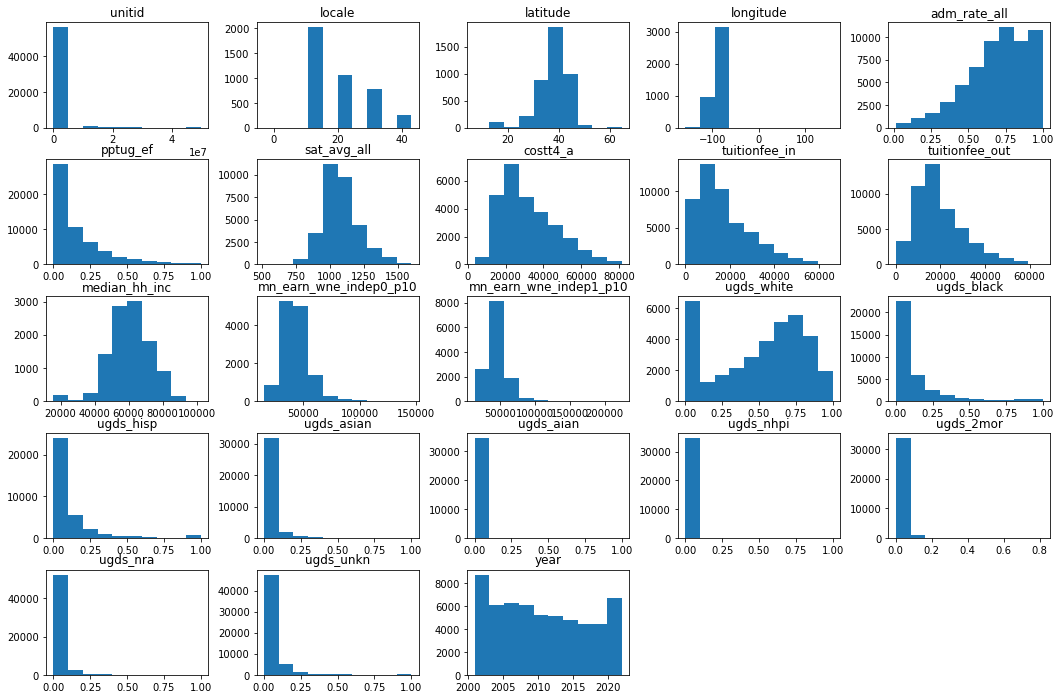

In [83]:
# histograms
University.hist(grid=False, figsize=(18,12))
plt.show()

Outliers with Z-score (Threshold 3?)

In [84]:
# In-state tuition data
tuitionfee_in_data = University['tuitionfee_in']

# Z-scores
z_scores_in = (tuitionfee_in_data - np.mean(tuitionfee_in_data)) / np.std(tuitionfee_in_data)
threshold = 3

# Find indices of outliers
outliers_in = np.where(np.abs(z_scores_in) > threshold)[0]

# Detail information about outliers
outlier_details = University.iloc[outliers_in]

# Print information about outliers
print("Outliers in tuitionfee_in:")
print(outlier_details)

# Summary statistics
print("\nSummary Statistics:")
print("Mean Tuition Fee:", np.mean(tuitionfee_in_data))
print("Median Tuition Fee:", np.median(tuitionfee_in_data))
print("Standard Deviation:", np.std(tuitionfee_in_data))
print("Number of Outliers:", len(outliers_in))

Outliers in tuitionfee_in:
         unitid                                             instnm  \
8622     438601  American InterContinental University-South Flo...   
11554    438601  American InterContinental University-South Flo...   
11821    103723                                    Collins College   
32176    447847  Aviator College of Aeronautical Science and Te...   
34778    447847  Aviator College of Aeronautical Science and Te...   
...         ...                                                ...   
57585    243744                                Stanford University   
57594    247649                                   Landmark College   
57700    441982             Franklin W Olin College of Engineering   
57855    487092                    Emory University-Oxford College   
58044  19457801      Pratt Manhattan-A Division of Pratt Institute   

              city stabbr         zip  \
8622        Weston     FL       33326   
11554       Weston     FL       33326   
11821    

In [85]:
# Sort on tuition fees
sorted_outliers = outlier_details.sort_values(by='tuitionfee_in')

largest_outlier = sorted_outliers.iloc[-1]
smallest_outlier = sorted_outliers.iloc[0]

print("Details of the largest outlier:")
print(largest_outlier)

print("\nDetails of the smallest outlier:")
print(smallest_outlier)

Details of the largest outlier:
unitid                                                               192040
instnm                               Jewish Theological Seminary of America
city                                                               New York
stabbr                                                                   NY
zip                                                              10027-4649
region                                         Mid East (DE DC MD NJ NY PA)
preddeg                            Predominantly bachelor's-degree granting
locale                                                                 11.0
latitude                                                          40.811893
longitude                                                         -73.96058
ccbasic                   Special Focus Four-Year: Faith-Related Institu...
ccugprof                  Four-year full-time more selective lower trans...
ccsizset                            Four-year very small

Biases of Degree Type and Institution Type

In [ ]:
# Degree Type Count
not_classified = df['PREDDEG'].value_counts()['Not classified']
graduate_degree = df['PREDDEG'].value_counts()['Entirely graduate-degree granting']
associate_degree = df['PREDDEG'].value_counts()['Predominantly associates-degree granting']
bachelors_degree = df['PREDDEG'].value_counts()['Predominantly bachelors-degree granting']
certificate = df['PREDDEG'].value_counts()['Predominantly certificate-degree granting']

In [ ]:
# Common degree at Universities Bar Graph
predominate_deg = df['PREDDEG'].value_counts()
fig = plt.figure()
predominate_deg.plot.bar(x ='lab', y='val', rot=0, width=0.99, 
                         color="blue")
plt.title ('Predominant Degrees Earned')
plt.xlabel('Degree Type') 
plt.ylabel('Count')
plt.show()

In [ ]:
# Institution Type Count
not_classified = df['CONTROL'].value_counts()['Private for-profit']
graduate_degree = df['CONTROL'].value_counts()['Private nonprofit']
associate_degree = df['CONTROL'].value_counts()['Public']

In [ ]:
# Institution Type Bar Graph
uni_type = df['CONTROL'].value_counts()
fig = plt.figure()
uni_type.plot.bar(x ='lab', y='val', rot=0, width=0.99, 
                         color="green")
plt.title ('Institution Type')
plt.xlabel('Institution Type') 
plt.ylabel('Count')
plt.show()

In [ ]:
Multicollinearity Test

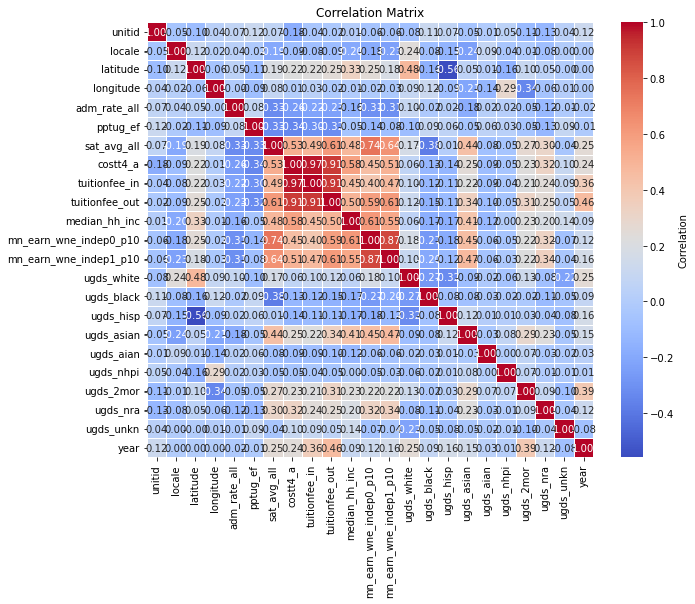

In [87]:
# assign correlation function to new variable
corr = University.corr()
corr

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=corr.isnull(), cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix')
plt.show()

Remove highly correlated variables

In [ ]:
# This is not representative of what we will drop yet. Of course in-state and out-of-state tutition of correlated, but will not be dropped. 
# Included it in case we find something interesting on joined table

In [88]:
cor_matrix = University.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),
                                     k=1).astype(bool))

to_drop = [column for column in upper_tri.columns if 
           any(upper_tri[column] > 0.80)]
print('Columns with chance of multicollinearity: %s'%to_drop)

Columns with chance of multicollinearity: ['tuitionfee_in', 'tuitionfee_out', 'mn_earn_wne_indep1_p10']


4. Data Preparation

In [ ]:
# Drop redundant columns
df = df.drop(columns=['#column names'])

In [ ]:
# Drop columns with potential multicollinearity
df = df.drop(columns=['#column names'])

In [ ]:
# Transform categorical variables
df['PREDDEG'].value_counts()
df['PREDDEG'] = df['PREDDEG'].map({'Not classified': 1,
                                   'Entirely graduate-degree granting': 2, 
                                   'Predominantly associates-degree granting': 3,
                                   'Predominantly bachelors-degree granting': 4, 
                                   'Predominantly certificate-degree granting':5,})

In [ ]:
df['CONTROL'].value_counts()
df['CONTROL'] = df['CONTROL'].map({'Private for-profit': 1,
                                   'Private nonprofit': 2, 
                                   'Public': 3,})

In [68]:
# Get null values for each column in the university dataset
null_cols_university = University.isnull().sum()
total_rows_university = University['unitid'].count()
percent_col_null_uni = null_cols_university / total_rows_university * 100
percent_col_null_uni.sort_values(ascending=False)

locale                    92.928789
latitude                  92.928789
longitude                 92.928789
median_hh_inc             81.676789
mn_earn_wne_indep0_p10    77.762676
mn_earn_wne_indep1_p10    77.482236
costt4_a                  51.877914
sat_avg_all               44.214855
ugds_hisp                 39.903309
ugds_white                39.903309
ugds_black                39.903309
ugds_asian                39.903309
ugds_aian                 39.903309
ugds_nhpi                 39.903309
ugds_2mor                 39.903309
tuitionfee_out            17.665984
tuitionfee_in             16.325723
pptug_ef                   4.528328
ugds_nra                   4.318428
ugds_unkn                  4.318428
unitid                     0.000000
control                    0.000000
instnm                     0.000000
adm_rate_all               0.000000
ccsizset                   0.000000
ccugprof                   0.000000
ccbasic                    0.000000
preddeg                    0

In [67]:
# Get null values for each column in the sticker price dataset
null_cols_sticker = StickerPrice.isnull().sum()
total_rows_sticker = StickerPrice['unit_id'].count()
percent_col_null_sticker = null_cols_sticker / total_rows_sticker * 100
percent_col_null_sticker.sort_values(ascending=False)

total_price_in_state_on_campus_2011_2012            43.765432
total_price_in_state_on_campus_2012_2013            43.518519
total_price_in_state_on_campus_2013_2014            42.901235
total_price_in_state_on_campus_2014_2015            42.592593
total_price_in_state_on_campus_2015_2016            42.037037
total_price_in_state_on_campus_2016_2017            41.820988
total_price_in_state_on_campus_2017_2018            41.141975
total_price_in_state_on_campus_2018_2019            40.524691
total_price_in_state_on_campus_2021_2022            40.061728
total_price_in_state_on_campus_2020_2021            40.000000
total_price_in_state_on_campus_2019_2020            40.000000
total_price_in_state_off_campus_wo_fam_2011_2012    21.697531
total_price_in_state_off_campus_w_fam_2011_2012     21.543210
total_price_in_state_off_campus_wo_fam_2012_2013    12.870370
total_price_in_state_off_campus_w_fam_2012_2013     12.592593
total_price_in_state_off_campus_wo_fam_2013_2014    10.524691
total_pr

In [69]:
# Get null values for each column in the net price dataset
null_cols_net = NetPrice.isnull().sum()
total_rows_net = NetPrice['unit_id'].count()
percent_col_null_net = null_cols_net / total_rows_net * 100
percent_col_null_net.sort_values(ascending=False)

avg_net_price_income_over_110k_titleiv_fed_finaid_2011_2012    64.259259
avg_net_price_income_over_110k_titleiv_fed_finaid_2012_2013    63.302469
avg_net_price_income_over_110k_titleiv_fed_finaid_2013_2014    62.654321
avg_net_price_income_over_110k_titleiv_fed_finaid_2015_2016    62.191358
avg_net_price_income_over_110k_titleiv_fed_finaid_2014_2015    61.666667
                                                                 ...    
avg_net_price_grants_scholarship_2019_2020                     51.728395
avg_net_price_grants_scholarship_2020_2021                     51.728395
institution_name                                                0.000000
sector                                                          0.000000
unit_id                                                         0.000000
Length: 63, dtype: float64

In [73]:
# Get null values for each column in the poverty dataset
null_cols_poverty = Poverty.isnull().sum()
total_rows_poverty = Poverty['fips_code'].count()
percent_col_null_poverty = null_cols_poverty / total_rows_poverty * 100
percent_col_null_poverty.sort_values(ascending=False)

med_hh_income_percent_of_state_total_2021    2.563320
median_household_income_2021                 2.532804
civilian_labor_force_2020                    2.532804
employed_2020                                2.532804
unemployed_2020                              2.532804
                                               ...   
unemployed_2021                              0.122063
employed_2021                                0.122063
state                                        0.000000
area_name                                    0.000000
fips_code                                    0.000000
Length: 100, dtype: float64

In [74]:
# Get null values for each column in the unemployment dataset
null_cols_unemployment = Unemployment.isnull().sum()
total_rows_unemployment = Unemployment['fips_code'].count()
percent_col_null_unemployment = null_cols_unemployment / total_rows_unemployment * 100
percent_col_null_unemployment.sort_values(ascending=False)

fips_code                          0.0
medhhinc_2021                      0.0
pov517_2021                        0.0
ci90lb517_2021                     0.0
ci90ub517_2021                     0.0
pctpov517_2021                     0.0
ci90lb517p_2021                    0.0
ci90ub517p_2021                    0.0
ci90lbinc_2021                     0.0
stabr                              0.0
ci90ubinc_2021                     0.0
pov04_2021                         0.0
ci90lb04_2021                      0.0
ci90ub04_2021                      0.0
pctpov04_2021                      0.0
ci90lb04p_2021                     0.0
ci90ub017p_2021                    0.0
ci90lb017p_2021                    0.0
pctpov017_2021                     0.0
ci90ub017_2021                     0.0
ci90lb017_2021                     0.0
pov017_2021                        0.0
ci90uballp_2021                    0.0
ci90lballp_2021                    0.0
pctpovall_2021                     0.0
ci90uball_2021           

Release SageMaker Resources

4. Train/Test

In [ ]:
# Define features and target variable
X = df.drop(columns=['COSTT4_A'])  
y = df['COSTT4_A']

# Split the data into train and temporary sets (70% train, 30% temp)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temporary set into validation and test sets (50% temp, 50% for validation and test)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the resulting sets
print("Train set shape:", X_train.shape)
print("Validation set shape:", X_valid.shape)
print("Test set shape:", X_test.shape)

In [ ]:
'''
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>
'''

In [ ]:
'''
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}
'''